# Tarea 8: 
## Oscar Esaú Peralta Rosales 
### Maestría en computación - CIMAT

In [0]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
from scipy import linalg, optimize
import matplotlib.pyplot as plt

import rosembrock
import wood

## Búsqueda en Linea

In [0]:
class LineSearch():
    def __init__(self, c1, c2):
        self.c1 = c1
        self.c2 = c2


    def __reset(self, f, g, x_k, g_k, p_k):
        self.f = f
        self.g = g
        self.x_k = x_k
        self.g_k = g_k
        self.p_k = p_k

    
    def search_scipy(self, f, g, x_k, g_k, p_k):
        self.__reset(f, g, x_k, g_k, p_k)
        return optimize.line_search(f, g, x_k, p_k)[0]


    def __armijo(self, alpha):
        t1 = self.__phi(alpha=alpha)
        t2 = self.__phi(0) + self.c1 * alpha * self.__phi_prime(alpha=0)
        return t1 <= t2


    def __phi(self, alpha):
        if alpha == 0: # To avoid extra operations
            return self.f(self.x_k)
        return self.f(self.x_k + alpha * self.p_k)


    def __phi_prime(self, alpha):
        if alpha == 0:
            return self.g_k.dot(self.p_k)
        return self.g(self.x_k + alpha * self.p_k).dot(self.p_k)


    def __cuadratic_interpolation(self, alpha_0):
        phi_prime_0 = self.__phi_prime(alpha=0)
        phi_a0 = self.__phi(alpha=alpha_0)
        phi_0 = self.__phi(alpha=0)

        a1 = (-alpha_0**2 * phi_prime_0) / (2*(phi_a0 - phi_prime_0*alpha_0 - phi_0))
        return a1


    def __cuadratic_interpolation_alg(self, alpha_0):
        alpha_1 = self.__cuadratic_interpolation(alpha_0)
        while not self.__armijo(alpha=alpha_1):
            alpha_1 = self.__cuadratic_interpolation(alpha_1)
        return alpha_1


    def __cubic_interpolation(self, alpha_0, alpha_1):
        f1 = alpha_1**2 * alpha_0**2 * (alpha_1 - alpha_0)

        m1 = np.array([
            [ alpha_0**2, -alpha_1**2],
            [-alpha_0**3,  alpha_1**3]
        ])

        phi_prime_0 = self.__phi_prime(alpha=0)
        phi_0 = self.__phi(0)
        m2 = np.array([
            [self.__phi(alpha=alpha_1) - phi_prime_0*alpha_1 - phi_0],
            [self.__phi(alpha=alpha_0) - phi_prime_0*alpha_0 - phi_0]
        ])
        a, b = (1.0 / f1) * (m1 @ m2)
        c = phi_prime_0

        return (-b + np.sqrt(b**2 - 3*a*c)) / (3*a)


    def __cubic_interpolation_alg(self, alpha_0, alpha_1):
        alpha_2 = self.__cubic_interpolation(alpha_0, alpha_1)
        while not self.__armijo(alpha=alpha_2):
            alpha_2 = self.__cubic_interpolation(alpha_0=alpha_1, alpha_1=alpha_2)
        return alpha_2


    def search_interpolation(self, f, g, x_k, g_k, p_k, alpha_0):
        self.__reset(f, g, x_k, g_k, p_k)

        if self.__armijo(alpha_0):
            return alpha_0
        alpha_1 = self.__cuadratic_interpolation(alpha_0)
        if self.__armijo(alpha_1):
            return alpha_1
        return self.__cubic_interpolation_alg(alpha_0, alpha_1)


    def __zoom(self, alpha_lo, alpha_hi):
        while True:
            alpha_j = self.__cubic_interpolation(alpha_lo, alpha_hi)

            phi_j = self.__phi(alpha_j)
            phi_0 = self.__phi(alpha=0)
            phi_prime_0 = self.__phi_prime(alpha=0)
            phi_lo = self.__phi(alpha=alpha_lo)
            if phi_j > phi_0 + self.c1 * alpha_j * phi_prime_0 or phi_j >= phi_lo:
                alpha_hi = alpha_j
            else:
                phi_prime_j = self.__phi_prime(alpha=alpha_j)
                if abs(phi_prime_j) <= -self.c2 * phi_prime_0:
                    return alpha_j
                if phi_prime_j*(alpha_hi - alpha_lo) >= 0:
                    alpha_hi = alpha_lo
                alpha_lo = alpha_j


    # Aún no funciona bien. Tengo que revisar
    def search_zoom(self, f, g, x_k, g_k, p_k, alpha, alpha_max):
        assert (alpha_max > 0 ), 'alpha_max must be greater than zero'
        assert (alpha > 0 and alpha < alpha_max), 'Invalid range for alpha'

        self.__reset(f, g, x_k, g_k, p_k)

        phi_prev = self.__phi(alpha=0)
        alpha_prev = 0
        alpha_i = alpha

        phi_prime_0 = self.__phi_prime(alpha=0)

        i = 1
        while True:
            phi_i = self.__phi(alpha=alpha_i)
            phi_0 = self.__phi(alpha=0)
            if phi_i > phi_0 + self.c1 * alpha_i * phi_prime_0 or (phi_i >= phi_prev and i > 1):
                return self.__zoom(alpha_prev, alpha_i)

            phi_prime_i = self.__phi_prime(alpha=alpha_i)
            if abs(phi_prime_i) <= - self.c2 * phi_prime_0:
                return alpha_i
            if phi_prime_i >= 0:
                return self.__zoom(alpha_i, alpha_prev)

            phi_prev = phi_i

            alpha_prev = alpha_i
            alpha_i = self.__cuadratic_interpolation(alpha_i)

            i += 1


    def search_backtracking(self, f, g, x_k, g_k, p_k, alpha, ro):
        self.__reset(f, g, x_k, g_k, p_k)
        while not self.__armijo(alpha):
            alpha = ro * alpha
        return alpha



## Algoritmo Cuasi-Newton DFP

In [0]:
class DFP():
    LS_VARIANTS = namedtuple('VARIANT', ['BACKTRACKING',
                                         'INTERPOLATION',
                                         'ZOOM',
                                         'SCIPY'])(0, 1, 2, 3)

    def __init__(self, ls_variant=0):
        self.__clear()
        self.ls_v = ls_variant


    def __clear(self):
        self.x_log = []
        self.f_log = []
        self.g_norm_log = []
        self.x_best = None
        self.iters = 0

    
    def __get_H_kn(self, H_k, y_k, s_k):
        Hy = H_k @ y_k
        return H_k - np.outer(Hy, Hy) / (Hy.dot(y_k)) + np.outer(s_k, s_k) / (y_k.dot(s_k))

    
    def __get_B_kn(self, B_k, y_k, s_k):
        Bs = B_k @ s_k
        return B_k - np.outer(Bs, Bs) / (Bs.dot(s_k)) + np.outer(y_k, y_k) / (s_k.dot(y_k))


    def optimize(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 H: np.array=None,
                 B: np.array=None,
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 variant=None,
                 **kwargs):
        self.__clear()
        
        line_search = LineSearch(c1=kwargs['c1'], c2=kwargs['c2'])

        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        
        assert(H is not None or B is not None), "Hessian aproximations are not provided"
        H_k = H
        B_k = B
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            if H is not None:
                d_k = - H_k @ g_k
            else:
                d_k = - np.linalg.inv(B_k) @ g_k
            
            if self.ls_v == self.LS_VARIANTS.SCIPY:
                alpha_k = line_search.search_scipy(f, g, x_k, g_k, d_k)
            if self.ls_v == self.LS_VARIANTS.BACKTRACKING:
                alpha_k = line_search.search_backtracking(f, g, x_k, g_k, d_k, kwargs['alpha'], kwargs['ro'])
            if self.ls_v == self.LS_VARIANTS.INTERPOLATION:
                alpha_k = line_search.search_interpolation(f, g, x_k, g_k, d_k, kwargs['alpha'])
            if self.ls_v == self.LS_VARIANTS.ZOOM:
                alpha_k = line_search.search_zoom(f, g, x_k, g_k, d_k, alpha=kwargs['alpha'], alpha_max=2)

            
            x_kn = x_k + alpha_k * d_k
            g_kn = g(x_kn, **kwargs.get('g_kwargs', {}))
            
            y_k = g_kn - g_k
            s_k = x_kn - x_k

            if H is not None:
                H_k = self.__get_H_kn(H_k, y_k, s_k)
            else:
                B_k = self.__get_B_kn(B_k, y_k, s_k)

            x_k = x_kn
            g_k = g_kn

            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k


### Prueba Rosembrock

iters: 40
g norm 8.370067658790327e-12
f error 3.986623854300933


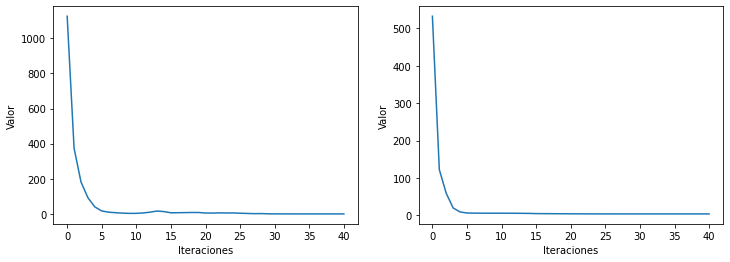

array([-0.9932861 ,  0.99665107,  0.99833032,  0.99916774,  0.9995852 ,
        0.99979328,  0.99989698,  0.99994866,  0.99997441,  0.99998725,
        0.99999365,  0.99999683,  0.99999842,  0.99999921,  0.99999961,
        0.9999998 ,  0.9999999 ,  0.99999995,  0.99999998,  0.99999999,
        0.99999999,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [369]:
X = np.ones(100, dtype=np.float64)
X[0] = X[-2] = -1.2

# X = np.ones(100, dtype=np.float128)
# X[4] = X[40] = 0.5

xop = np.ones(100)

B_0 = rosembrock.hessian(X)
H_0 = np.linalg.inv(B_0)

params = {
    'X': X,
    'f': rosembrock.function,
    'g': rosembrock.gradient,
    # 'H': H_0,
    'B': B_0,
    'tol_g': 1e-8,
    'mxitr': 10000,
    'alpha': 1,
    'c1': 0.3,
    'c2': 0.4,
    'ro': 0.8,
}

dfp = DFP(ls_variant=DFP.LS_VARIANTS.INTERPOLATION)
dfp.optimize(**params)

print("iters: %d" % dfp.iters)
print("g norm", np.linalg.norm(dfp.g_norm_log[-1]))
print("f error", dfp.f_log[-1] - rosembrock.function(xop))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(dfp.g_norm_log)
ax1.set(xlabel='Iteraciones', ylabel='Valor')
ax2.plot(dfp.f_log)
ax2.set(xlabel='Iteraciones', ylabel='Valor')
plt.show()

dfp.x_best

In [384]:
nruns = 30

X = np.random.rand(nruns, 100)

times = []
iters = []
g_norms = []

B_0 = np.identity(X.shape[1])

for i in range(nruns):
# for i in range(1):
    params = {
        'X': X[i],
        'f': rosembrock.function,
        'g': rosembrock.gradient,
        'B': B_0,
        'tol_g': 1e-8,
        'mxitr': 10000,
        'alpha': 1,
        'c1': 0.5,
        'c2': 0.4,
        'ro': 0.8,
    }

    dfp = DFP(ls_variant=DFP.LS_VARIANTS.BACKTRACKING)

    tic = time.time()
    dfp.optimize(**params)
    toc = time.time()

    times.append(toc - tic)
    iters.append(dfp.iters)
    g_norms.append(np.linalg.norm(dfp.g_norm_log[-1]))
    print(dfp.x_best)


print("Time:", np.mean(times))
print("iters:", np.mean(iters))
print("g norm:", np.mean(g_norms))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.

### Prueba Wood

iters: 76
g norm 8.193280874135609e-10
f error 2.453665495174449e-21


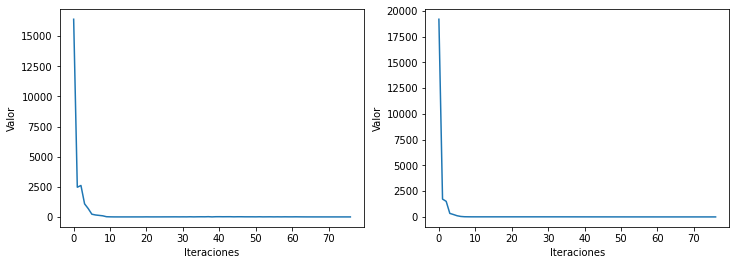

array([1., 1., 1., 1.])

In [12]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)

# X = np.array([0.7, 0.5, 0.1, 0.8], dtype=np.float128)

xop = np.ones(4)


B_0 = wood.hessian(X)
H_0 = np.linalg.inv(B_0)

B_0 = np.identity(X.shape[0])

params = {
    'X': X,
    'f': wood.function,
    'g': wood.gradient,
    # 'H': H_0,
    'B': B_0,
    'tol_g': 1e-8,
    'mxitr': 10000,
    'alpha': 1,
    'c1': 0.4,
    'c2': 0.5,
    'ro': 0.7,
}

dfp = DFP(ls_variant=DFP.LS_VARIANTS.BACKTRACKING)
dfp.optimize(**params)

print("iters: %d" % dfp.iters)
print("g norm", np.linalg.norm(dfp.g_norm_log[-1]))
print("f error", dfp.f_log[-1] - wood.function(xop))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(dfp.g_norm_log)
ax1.set(xlabel='Iteraciones', ylabel='Valor')
ax2.plot(dfp.f_log)
ax2.set(xlabel='Iteraciones', ylabel='Valor')
plt.show()

dfp.x_best

In [385]:
nruns = 30

X = np.random.rand(nruns, 4)

xop = np.ones(4)

times = []
iters = []
g_norms = []

# B_0 = wood.hessian(X[i])
B_0 = np.identity(X[i].shape[0])

for i in range(nruns):
    params = {
        'X': X[i],
        'f': wood.function,
        'g': wood.gradient,
        'B': B_0,
        'tol_g': 1e-8,
        'mxitr': 10000,
        'alpha': 1,
        'c1': 0.4,
        'c2': 0.5,
        'ro': 0.7,
    }

    dfp = DFP(ls_variant=DFP.LS_VARIANTS.SCIPY)
    
    tic = time.time()
    dfp.optimize(**params)
    toc = time.time()

    times.append(toc - tic)
    iters.append(dfp.iters)
    g_norms.append(np.linalg.norm(dfp.g_norm_log[-1]))

print("Time:", np.mean(times))
print("iters:", np.mean(iters))
print("g norm:", np.mean(g_norms))


Time: 0.008601077397664388
iters: 26.266666666666666
g norm: 2.493940209218946e-09


## Algoritmo Cuasi-Newton BFGS

In [0]:
class BFGS():
    LS_VARIANTS = namedtuple('VARIANT', ['BACKTRACKING',
                                         'INTERPOLATION',
                                         'ZOOM',
                                         'SCIPY'])(0, 1, 2, 3)

    def __init__(self, ls_variant=0):
        self.__clear()
        self.ls_v = ls_variant


    def __clear(self):
        self.x_log = []
        self.f_log = []
        self.g_norm_log = []
        self.x_best = None
        self.iters = 0
        self.I = None

    
    def __get_H_kn(self, H_k, y_k, s_k):
        if self.I is None:
            self.I = np.identity(s_k.shape[0])

        ro_k = 1.0 / s_k.dot(y_k)
        ML = (self.I - ro_k * np.outer(s_k, y_k))
        MR = (self.I - ro_k * np.outer(y_k, s_k)) 
        
        return  (ML @ H_k @ MR) + ro_k * np.outer(s_k, s_k)



    def optimize(self,
                 X: np.array,
                 f: Callable[[np.array], np.array],
                 g: Callable[[np.array], np.array],
                 H: np.array=None,
                 tol_g: float=1e-12,
                 mxitr: int=1000,
                 variant=None,
                 **kwargs):
        self.__clear()
        
        line_search = LineSearch(c1=kwargs['c1'], c2=kwargs['c2'])

        x_k = X
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        
        H_k = H
        
        self.x_log.append(x_k)
        self.g_norm_log.append(np.linalg.norm(g_k))
        self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))
        
        while self.g_norm_log[-1] > tol_g and self.iters < mxitr:
            d_k = - H_k @ g_k
            
            if self.ls_v == self.LS_VARIANTS.SCIPY:
                alpha_k = line_search.search_scipy(f, g, x_k, g_k, d_k)
            if self.ls_v == self.LS_VARIANTS.BACKTRACKING:
                alpha_k = line_search.search_backtracking(f, g, x_k, g_k, d_k, kwargs['alpha'], kwargs['ro'])
            if self.ls_v == self.LS_VARIANTS.INTERPOLATION:
                alpha_k = line_search.search_interpolation(f, g, x_k, g_k, d_k, kwargs['alpha'])
            if self.ls_v == self.LS_VARIANTS.ZOOM:
                alpha_k = line_search.search_zoom(f, g, x_k, g_k, d_k, alpha=kwargs['alpha'], alpha_max=2)

            
            x_kn = x_k + alpha_k * d_k
            g_kn = g(x_kn, **kwargs.get('g_kwargs', {}))
            
            y_k = g_kn - g_k
            s_k = x_kn - x_k

            H_k = self.__get_H_kn(H_k, y_k, s_k)

            x_k = x_kn
            g_k = g_kn

            self.x_log.append(x_k)
            self.g_norm_log.append(np.linalg.norm(g_k))
            self.f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

            self.iters +=1

        self.x_best = x_k


### Prueba Rosembrock

iters: 40
g norm 8.370067658790327e-12
f error 3.986623854300933


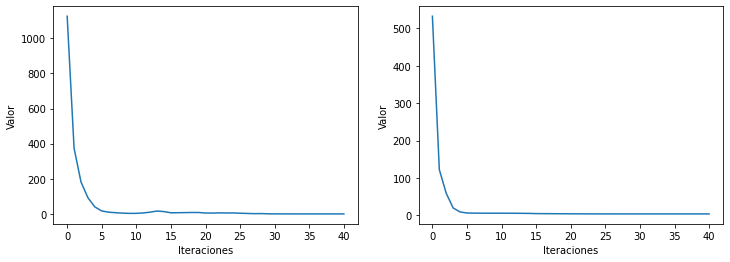

array([-0.9932861 ,  0.99665107,  0.99833032,  0.99916774,  0.9995852 ,
        0.99979328,  0.99989698,  0.99994866,  0.99997441,  0.99998725,
        0.99999365,  0.99999683,  0.99999842,  0.99999921,  0.99999961,
        0.9999998 ,  0.9999999 ,  0.99999995,  0.99999998,  0.99999999,
        0.99999999,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [355]:
X = np.ones(100, dtype=np.float64)
X[0] = X[-2] = -1.2

# X = np.ones(100, dtype=np.float128)
# X[4] = X[40] = 0.5

xop = np.ones(100)

B_0 = rosembrock.hessian(X)
H_0 = np.linalg.inv(B_0)

# X = np.random.rand(100)
# H_0 = np.identity(X.shape[0])

params = {
    'X': X,
    'f': rosembrock.function,
    'g': rosembrock.gradient,
    'H': H_0,
    # 'B': B_0,
    'tol_g': 1e-8,
    'mxitr': 10000,
    'alpha': 1,
    'c1': 0.3,
    'c2': 0.4,
    'ro': 0.8,
}

bfgs = BFGS(ls_variant=BFGS.LS_VARIANTS.INTERPOLATION)
bfgs.optimize(**params)

print("iters: %d" % bfgs.iters)
print("g norm", np.linalg.norm(bfgs.g_norm_log[-1]))
print("f error", bfgs.f_log[-1] - rosembrock.function(xop))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(bfgs.g_norm_log)
ax1.set(xlabel='Iteraciones', ylabel='Valor')
ax2.plot(bfgs.f_log)
ax2.set(xlabel='Iteraciones', ylabel='Valor')
plt.show()

bfgs.x_best

In [364]:
nruns = 30

X = np.random.rand(nruns, 100)

times = []
iters = []
g_norms = []

H_0 = np.identity(X.shape[1])

for i in range(nruns):
# for i in range(1):
    params = {
        'X': X[i],
        'f': rosembrock.function,
        'g': rosembrock.gradient,
        'H': H_0,
        'tol_g': 1e-8,
        'mxitr': 10000,
        'alpha': 1,
        'c1': 0.5,
        'c2': 0.4,
        'ro': 0.8,
    }

    bfgs = BFGS(ls_variant=BFGS.LS_VARIANTS.BACKTRACKING)

    tic = time.time()
    bfgs.optimize(**params)
    toc = time.time()

    times.append(toc - tic)
    iters.append(bfgs.iters)
    g_norms.append(np.linalg.norm(bfgs.g_norm_log[-1]))
    print(bfgs.x_best)


print("Time:", np.mean(times))
print("iters:", np.mean(iters))
print("g norm:", np.mean(g_norms))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.

### Prueba Wood

iters: 84
g norm 4.745193082751641e-10
f error 1.3332687901456904e-22


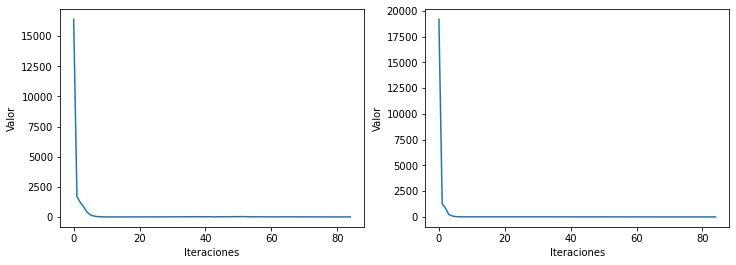

array([1., 1., 1., 1.])

In [389]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)

# X = np.array([0.7, 0.5, 0.1, 0.8], dtype=np.float128)

xop = np.ones(4)


B_0 = wood.hessian(X)
H_0 = np.linalg.inv(B_0)

params = {
    'X': X,
    'f': wood.function,
    'g': wood.gradient,
    'H': H_0,
    'tol_g': 1e-8,
    'mxitr': 10000,
    'alpha': 1,
    'c1': 0.4,
    'c2': 0.5,
    'ro': 0.7,
}

bfgs = BFGS(ls_variant=BFGS.LS_VARIANTS.BACKTRACKING)
bfgs.optimize(**params)

print("iters: %d" % bfgs.iters)
print("g norm", np.linalg.norm(bfgs.g_norm_log[-1]))
print("f error", bfgs.f_log[-1] - wood.function(xop))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(bfgs.g_norm_log)
ax1.set(xlabel='Iteraciones', ylabel='Valor')
ax2.plot(bfgs.f_log)
ax2.set(xlabel='Iteraciones', ylabel='Valor')
plt.show()

bfgs.x_best

In [390]:
nruns = 30

X = np.random.rand(nruns, 4)

xop = np.ones(4)

times = []
iters = []
g_norms = []

H_0 = np.identity(X[i].shape[0])

for i in range(nruns):
    params = {
        'X': X[i],
        'f': wood.function,
        'g': wood.gradient,
        'H': H_0,
        'tol_g': 1e-8,
        'mxitr': 10000,
        'alpha': 1,
        'c1': 0.4,
        'c2': 0.5,
        'ro': 0.7,
    }
    bfgs = BFGS(ls_variant=BFGS.LS_VARIANTS.SCIPY)
    
    tic = time.time()
    bfgs.optimize(**params)
    toc = time.time()

    times.append(toc - tic)
    iters.append(bfgs.iters)
    g_norms.append(np.linalg.norm(bfgs.g_norm_log[-1]))

print("Time:", np.mean(times))
print("iters:", np.mean(iters))
print("g norm:", np.mean(g_norms))

Time: 0.005094353357950846
iters: 26.7
g norm: 2.202837184315701e-09
